In [229]:
#Importamos todas las librerias que vamos a usar y la BBDD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import pyodbc 
from datetime import date,datetime,timedelta
from sklearn import model_selection
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree,DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,recall_score,precision_score,plot_confusion_matrix
import scipy as sp
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


# conexion = pyodbc.connect('Driver={SQL Server};'
#                       'Server=DESKTOP-C6JNHNC\SQLEXPRESS;'
#                       'Database=TRABAJO;'
#                       'Trusted_Connection=yes;')

# df=pd.read_sql("""SELECT * FROM PREINSCRIPCION
#  """,conexion)

Archivo="C:/Users/SEBAS/Desktop/Proyecto inscripcion csv.csv"

df=pd.read_csv(Archivo,sep=";")



In [230]:

df.head()

,TIPO,IDENTIFICACION,APELLIDO,NOMBRE,CARRERA_INDEFINIDA,INSCRIPCION,DOCUMENTACION,MATRICULA,EMAIL,TELEFONO,SEDE,SEXO,RESIDENCIA,TITULO,EGRESO,UNIVERSIDAD,NACIMIENTO,POSGRADO
0,NaN,1,1A,3E,ESPECIALIZACIO R,2020-08-14 00:00:00.0000000,1,0,CORREO@,Numero X,SEDE X,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,NaN,2,2B,4F,MAESTR Y,2020-08-14 00:00:00.0000000,1,1,CORREO@,Numero X,SEDE X,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,NaN,3,2a,3E,MAESTR Z,2021-07-08 00:00:00.0000000,0,0,CORREO@,Numero X,SEDE Y,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,NaN,4,2B,4F,DOCTORADO Y,2021-02-07 00:00:00.0000000,1,0,CORREO@,Numero X,SEDE X,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,NaN,5,3a,3E,MAESTR X,2022-02-28 00:00:00.0000000,1,0,CORREO@,Numero X,SEDE X,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [231]:
# Vemos el nombre de las columnas
df.columns

Index(['TIPO', 'IDENTIFICACION', 'APELLIDO', 'NOMBRE', 'CARRERA_INDEFINIDA',
       'INSCRIPCION', 'DOCUMENTACION', 'MATRICULA', 'EMAIL', 'TELEFONO',
       'SEDE', 'SEXO', 'RESIDENCIA', 'TITULO', 'EGRESO', 'UNIVERSIDAD',
       'NACIMIENTO', 'POSGRADO'],
      dtype='object')

In [232]:
#Observamos la cardinalidad de las variables y cuales pueden tener uso potencial
df.nunique()



TIPO                    1
IDENTIFICACION        644
APELLIDO              323
NOMBRE                  2
CARRERA_INDEFINIDA     14
INSCRIPCION           192
DOCUMENTACION           2
MATRICULA               2
EMAIL                   1
TELEFONO                1
SEDE                    2
SEXO                    2
RESIDENCIA              2
TITULO                  2
EGRESO                  1
UNIVERSIDAD             2
NACIMIENTO              1
POSGRADO                3
dtype: int64

In [233]:
# Vemos que el 75% de los preinscriptos, entregaron la documentacion. Que es el paso previo
df["DOCUMENTACION"].value_counts(normalize=True)

1    0.753106
0    0.246894
Name: DOCUMENTACION, dtype: float64

In [234]:
#Dropeamos las columnas que no tienen inferencia y renombramos algunas
df.drop(columns=["TIPO","IDENTIFICACION","APELLIDO","NOMBRE","EMAIL","TELEFONO","SEXO","RESIDENCIA","TITULO","EGRESO","UNIVERSIDAD","NACIMIENTO"],inplace=True)

df.rename(columns={"0":"Consultas"},inplace=True)

df["DOCUMENTACION"].value_counts()

1    485
0    159
Name: DOCUMENTACION, dtype: int64

In [235]:
#Creamos una nueva carrera que clasifique los posgrados.

condiciones=[(df["CARRERA_INDEFINIDA"].str.find("ESPECIALIZACION")!=1) &(df["CARRERA_INDEFINIDA"].str.find("MAESTR")==-1) & (df["CARRERA_INDEFINIDA"].str.find("DOCTORADO")==-1),
(df["CARRERA_INDEFINIDA"].str.find("ESPEC")==-1) &(df["CARRERA_INDEFINIDA"].str.find("MAESTR")!=-1) & (df["CARRERA_INDEFINIDA"].str.find("DOCTORADO")==-1),
(df["CARRERA_INDEFINIDA"].str.find("ESPEC")==-1) &(df["CARRERA_INDEFINIDA"].str.find("MAESTR")==-1) & (df["CARRERA_INDEFINIDA"].str.find("DOCTORADO")!=-1)]

listadorespuestas=[0,1,2]

df["POSGRADO"]=np.select(condiciones,listadorespuestas)

df.head()



# df["DOCUMENTACION"].replace("True","1")
# df["DOCUMENTACION"].replace("False","0")
# df["MATRICULA"].replace("True","1")
# df["MATRICULA"].replace("False","1")


,CARRERA_INDEFINIDA,INSCRIPCION,DOCUMENTACION,MATRICULA,SEDE,POSGRADO
0,ESPECIALIZACIO R,2020-08-14 00:00:00.0000000,1,0,SEDE X,0
1,MAESTR Y,2020-08-14 00:00:00.0000000,1,1,SEDE X,1
2,MAESTR Z,2021-07-08 00:00:00.0000000,0,0,SEDE Y,1
3,DOCTORADO Y,2021-02-07 00:00:00.0000000,1,0,SEDE X,2
4,MAESTR X,2022-02-28 00:00:00.0000000,1,0,SEDE X,1


In [236]:
#Transformamos la columna con la fecha de inscripcion en Datetime
#Posteriormente, creamos una nueva columna que indique dia, mes y año.
df["INSCRIPCION"]=pd.to_datetime(df["INSCRIPCION"])
df["INSCRIPCION"].dt.strftime('%d,%m,%Y')

df["AÑO"]=df["INSCRIPCION"].dt.strftime("%Y")
df["MES"]=df["INSCRIPCION"].dt.strftime("%m")
df["DIA"]=df["INSCRIPCION"].dt.strftime("%d")


df["MES"]=pd.to_numeric(df["MES"])
df["DIA"]=pd.to_numeric(df["DIA"])

# df.drop(columns=["INSCRIPCION"],inplace=True)

df

,CARRERA_INDEFINIDA,INSCRIPCION,DOCUMENTACION,MATRICULA,SEDE,POSGRADO,AÑO,MES,DIA
0,ESPECIALIZACIO R,2020-08-14,1,0,SEDE X,0,2020,8,14
1,MAESTR Y,2020-08-14,1,1,SEDE X,1,2020,8,14
2,MAESTR Z,2021-07-08,0,0,SEDE Y,1,2021,7,8
3,DOCTORADO Y,2021-02-07,1,0,SEDE X,2,2021,2,7
4,MAESTR X,2022-02-28,1,0,SEDE X,1,2022,2,28
...,...,...,...,...,...,...,...,...,...
639,DOCTORADO Y,2022-02-09,0,0,SEDE X,2,2022,2,9
640,MAESTR X,2022-02-08,1,0,SEDE X,1,2022,2,8
641,DOCTORADO Z,2021-03-18,0,0,SEDE Y,2,2021,3,18
642,DOCTORADO Y,2022-02-06,0,0,SEDE X,2,2022,2,6


In [237]:
#Creamos una nueva columna que indique si es el 1er o 2do cuatrimestre

nuevascondiciones=[(df["MES"]>4),df["MES"]<=4]

respuestas=[int(2),int(1)]

df["CUATRIMESTRE"]=np.select(nuevascondiciones,respuestas)

df


,CARRERA_INDEFINIDA,INSCRIPCION,DOCUMENTACION,MATRICULA,SEDE,POSGRADO,AÑO,MES,DIA,CUATRIMESTRE
0,ESPECIALIZACIO R,2020-08-14,1,0,SEDE X,0,2020,8,14,2
1,MAESTR Y,2020-08-14,1,1,SEDE X,1,2020,8,14,2
2,MAESTR Z,2021-07-08,0,0,SEDE Y,1,2021,7,8,2
3,DOCTORADO Y,2021-02-07,1,0,SEDE X,2,2021,2,7,1
4,MAESTR X,2022-02-28,1,0,SEDE X,1,2022,2,28,1
...,...,...,...,...,...,...,...,...,...,...
639,DOCTORADO Y,2022-02-09,0,0,SEDE X,2,2022,2,9,1
640,MAESTR X,2022-02-08,1,0,SEDE X,1,2022,2,8,1
641,DOCTORADO Z,2021-03-18,0,0,SEDE Y,2,2021,3,18,1
642,DOCTORADO Y,2022-02-06,0,0,SEDE X,2,2022,2,6,1


In [238]:
#Agregamos columnas para indicar fecha de apertura y cierre de la inscripcion 
#pero de forma transitoria.

otrascondiciones=[(df["AÑO"]=="2020") & (df["CUATRIMESTRE"]==1),
(df["AÑO"]=="2020") & (df["CUATRIMESTRE"]==2),
(df["AÑO"]=="2021") & (df["CUATRIMESTRE"]==1),
(df["AÑO"]=="2021") & (df["CUATRIMESTRE"]==2),
(df["AÑO"]=="2022") & (df["CUATRIMESTRE"]==1),
(df["AÑO"]=="2022") & (df["CUATRIMESTRE"]==2)]



resultados=["2020/02/01","2020/06/29","2021/02/01","2021/06/07","2022/02/01","2022/06/05"]
cierres=["2020/02/01","2020/07/15","2021/03/31","2021/08/12","2022/03/15","2022/06/05"]

df["APERTURA"]=np.select(otrascondiciones,resultados)
df["CIERRE"]=np.select(otrascondiciones,cierres)



df

,CARRERA_INDEFINIDA,INSCRIPCION,DOCUMENTACION,MATRICULA,SEDE,POSGRADO,AÑO,MES,DIA,CUATRIMESTRE,APERTURA,CIERRE
0,ESPECIALIZACIO R,2020-08-14,1,0,SEDE X,0,2020,8,14,2,2020/06/29,2020/07/15
1,MAESTR Y,2020-08-14,1,1,SEDE X,1,2020,8,14,2,2020/06/29,2020/07/15
2,MAESTR Z,2021-07-08,0,0,SEDE Y,1,2021,7,8,2,2021/06/07,2021/08/12
3,DOCTORADO Y,2021-02-07,1,0,SEDE X,2,2021,2,7,1,2021/02/01,2021/03/31
4,MAESTR X,2022-02-28,1,0,SEDE X,1,2022,2,28,1,2022/02/01,2022/03/15
...,...,...,...,...,...,...,...,...,...,...,...,...
639,DOCTORADO Y,2022-02-09,0,0,SEDE X,2,2022,2,9,1,2022/02/01,2022/03/15
640,MAESTR X,2022-02-08,1,0,SEDE X,1,2022,2,8,1,2022/02/01,2022/03/15
641,DOCTORADO Z,2021-03-18,0,0,SEDE Y,2,2021,3,18,1,2021/02/01,2021/03/31
642,DOCTORADO Y,2022-02-06,0,0,SEDE X,2,2022,2,6,1,2022/02/01,2022/03/15


In [239]:
df["APERTURA"]=pd.to_datetime(df["APERTURA"])
df["CIERRE"]=pd.to_datetime(df["CIERRE"])
df["DIASDESDEINSC"]=(df["INSCRIPCION"]-df["APERTURA"]).dt.days
df["DIASANTESDELCIERRE"]=(df["CIERRE"]-df["INSCRIPCION"]).dt.days
df["HABILITADO"]=(df["CIERRE"]-df["APERTURA"]).dt.days


In [240]:
df.drop(columns=["CIERRE","APERTURA","INSCRIPCION"],inplace=True)

In [241]:
df

,CARRERA_INDEFINIDA,DOCUMENTACION,MATRICULA,SEDE,POSGRADO,AÑO,MES,DIA,CUATRIMESTRE,DIASDESDEINSC,DIASANTESDELCIERRE,HABILITADO
0,ESPECIALIZACIO R,1,0,SEDE X,0,2020,8,14,2,46,-30,16
1,MAESTR Y,1,1,SEDE X,1,2020,8,14,2,46,-30,16
2,MAESTR Z,0,0,SEDE Y,1,2021,7,8,2,31,35,66
3,DOCTORADO Y,1,0,SEDE X,2,2021,2,7,1,6,52,58
4,MAESTR X,1,0,SEDE X,1,2022,2,28,1,27,15,42
...,...,...,...,...,...,...,...,...,...,...,...,...
639,DOCTORADO Y,0,0,SEDE X,2,2022,2,9,1,8,34,42
640,MAESTR X,1,0,SEDE X,1,2022,2,8,1,7,35,42
641,DOCTORADO Z,0,0,SEDE Y,2,2021,3,18,1,45,13,58
642,DOCTORADO Y,0,0,SEDE X,2,2022,2,6,1,5,37,42


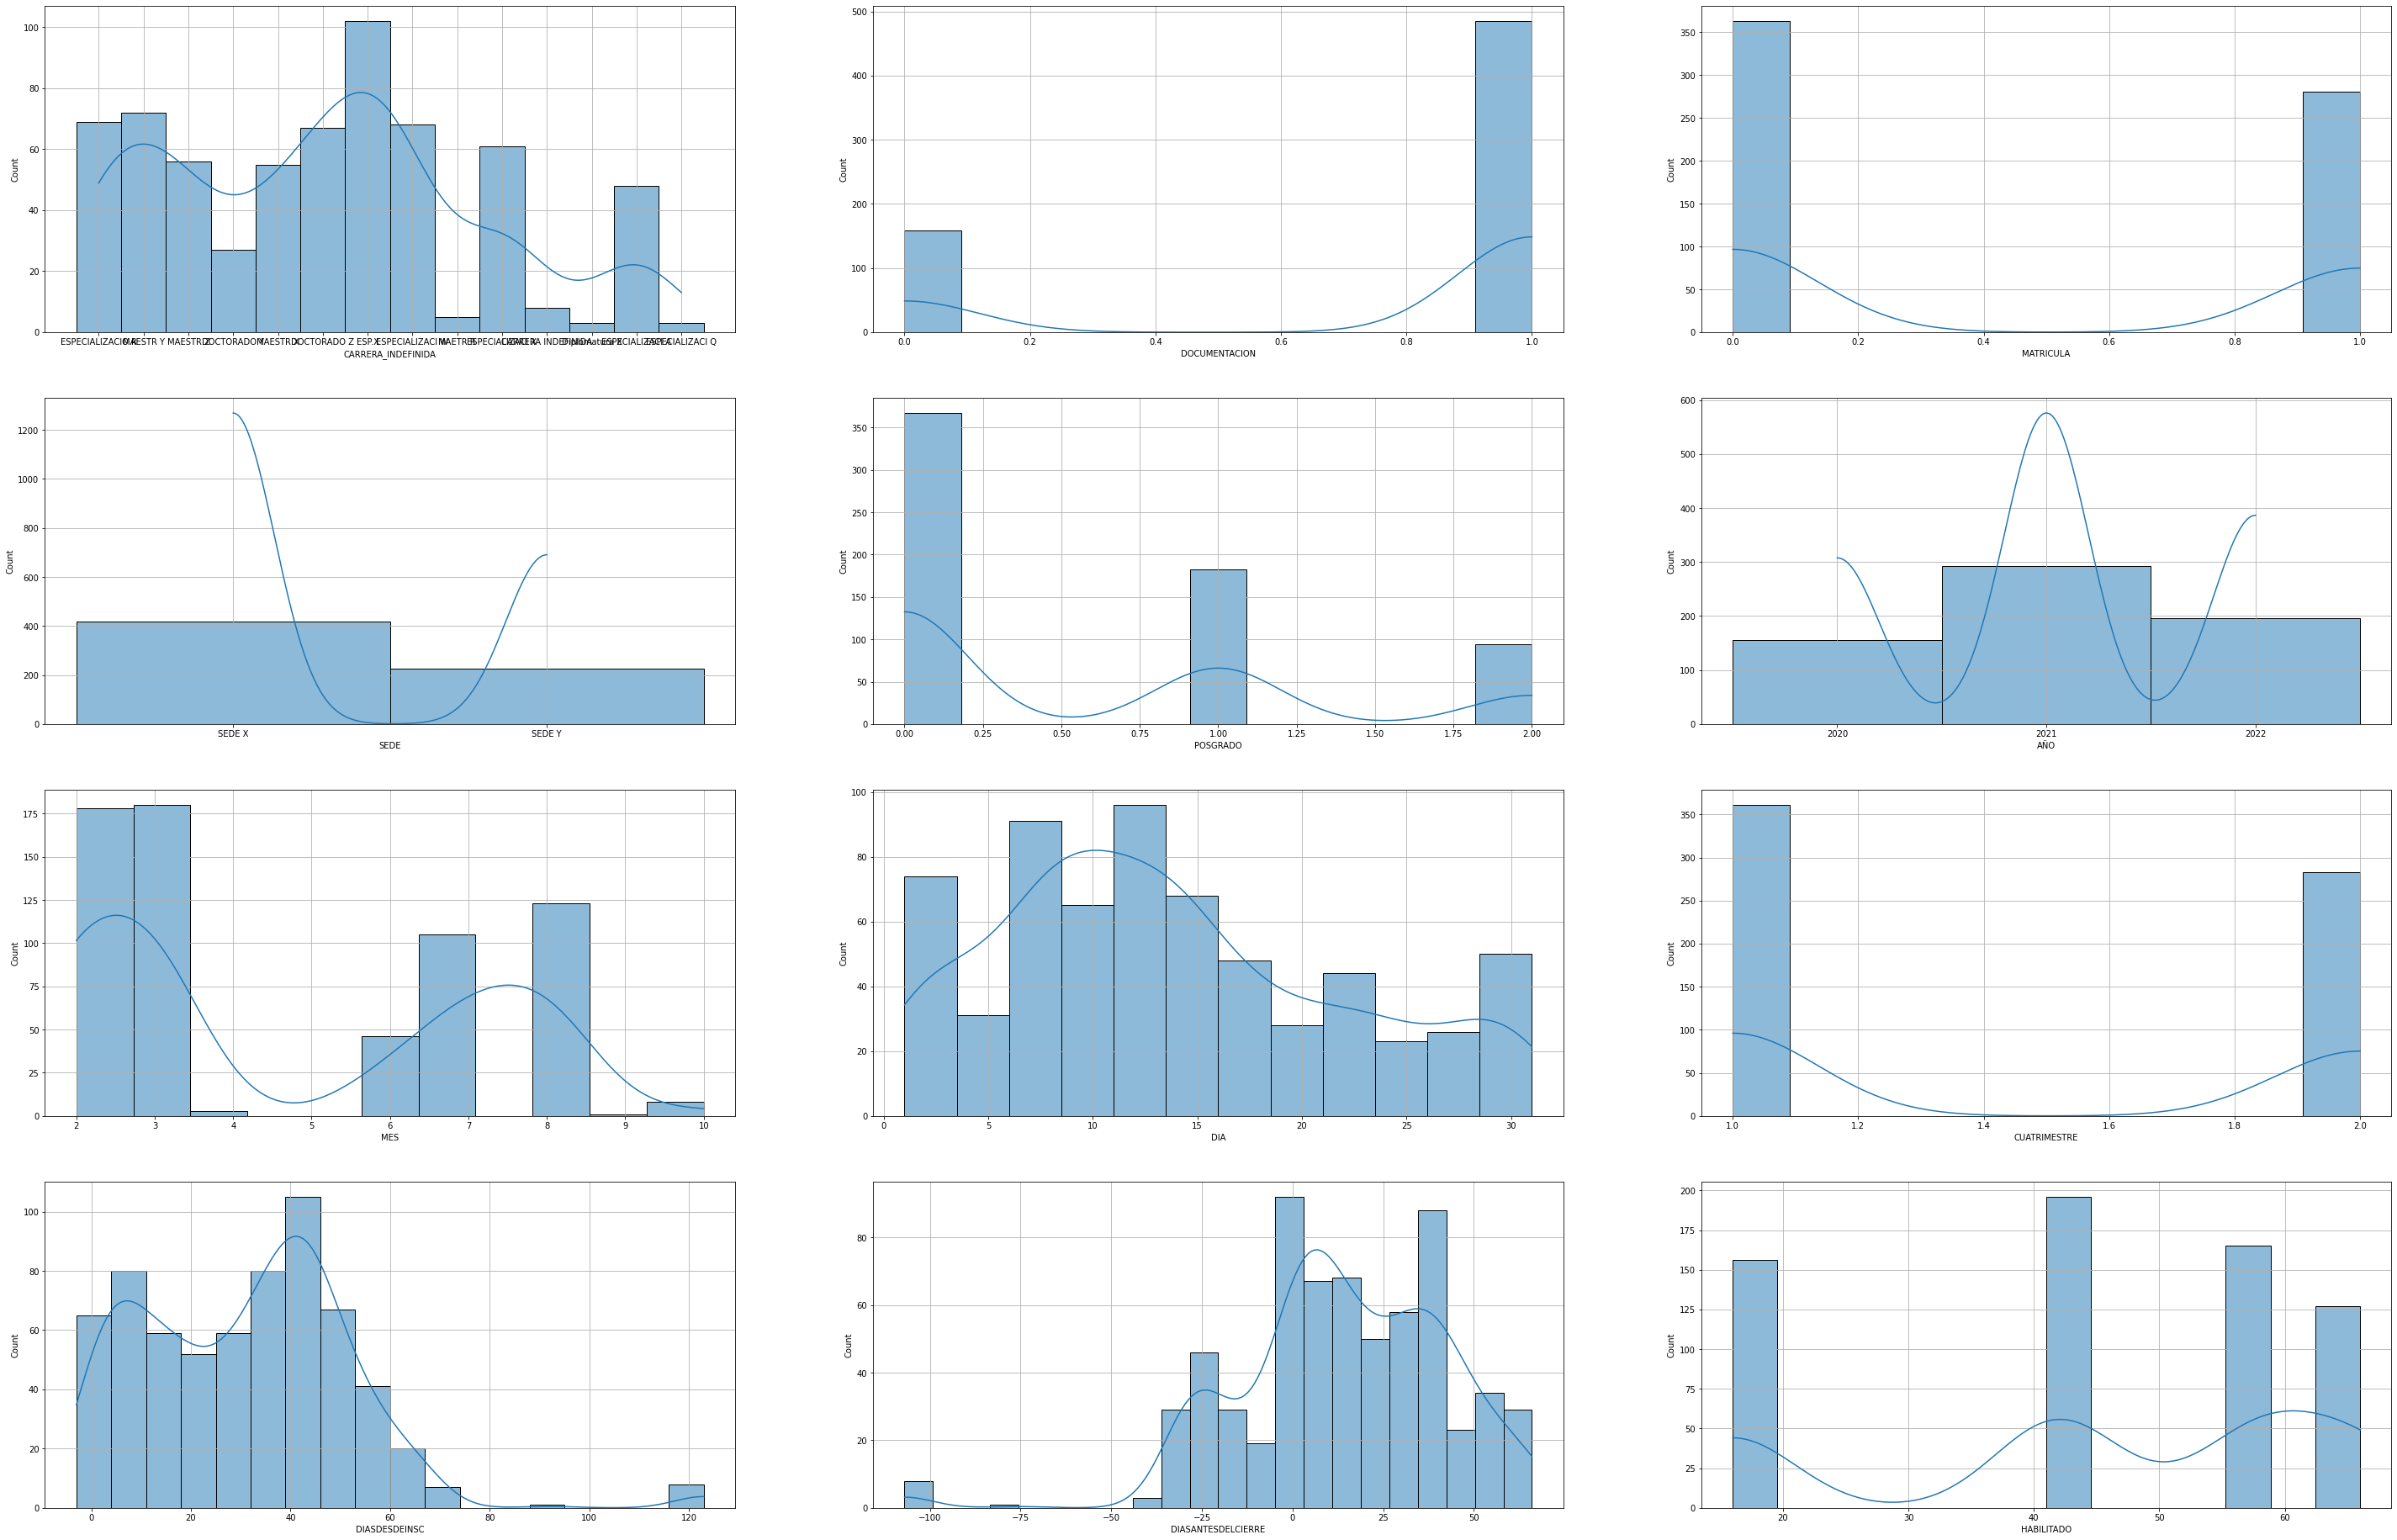

In [242]:
#Algunos graficos entre variables

plt.figure(figsize=(50,50))
idx = 1

for var in df.columns.values.tolist():
    ax = plt.subplot(6,3,idx)
    sns.histplot(data=df, x=var, kde=True)
    plt.grid()
    idx+=1
plt.show()

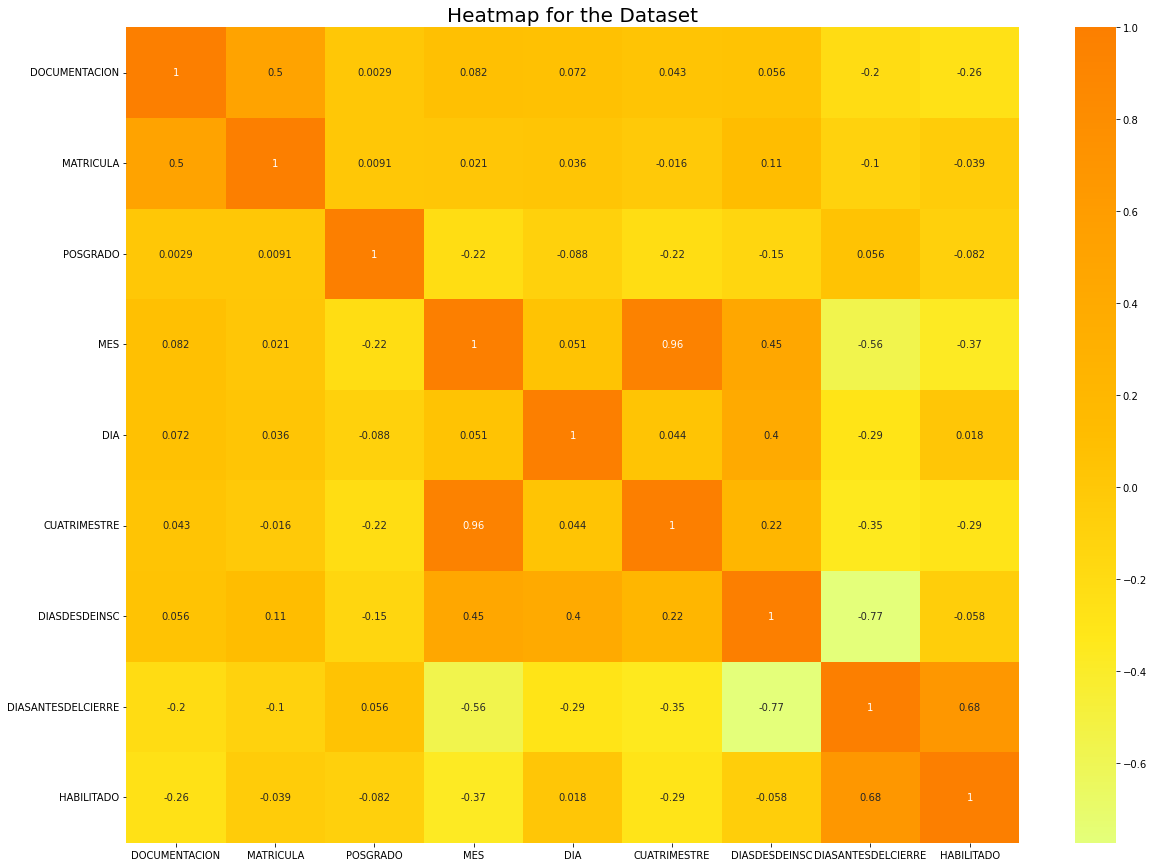

In [243]:
#Grafico de calor

plt.rcParams['figure.figsize'] = (20, 15)

sns.heatmap(df.corr(), annot = True, cmap = 'Wistia')
plt.title('Heatmap for the Dataset', fontsize = 20)
plt.show()

In [244]:
#Comenzamos a transformar todas las variables a numericas con get_dummies.
dummies = pd.get_dummies(df['CARRERA_INDEFINIDA'], drop_first = True)

df = pd.concat([df, dummies], axis = 1)

df = df.drop(columns=['CARRERA_INDEFINIDA'])

dummies=pd.get_dummies(df["SEDE"],drop_first=True)

df=pd.concat([df,dummies],axis=1)

df=df.drop(columns=["SEDE"])

dummies = pd.get_dummies(df['AÑO'], drop_first = True)


df = pd.concat([df, dummies], axis = 1)


df = df.drop(columns=['AÑO'])

df["DOCUMENTACION"].replace(True,1,inplace=True)
df["DOCUMENTACION"].replace(False,0,inplace=True)
df["MATRICULA"].replace(True,1,inplace=True)
df["MATRICULA"].replace(False,0,inplace=True)

df.head()


,DOCUMENTACION,MATRICULA,POSGRADO,MES,DIA,CUATRIMESTRE,DIASDESDEINSC,DIASANTESDELCIERRE,HABILITADO,DOCTORADO Y,...,ESPECIALIZACI W,ESPECIALIZACI X,ESPECIALIZACIO R,MAESTR X,MAESTR Y,MAESTR Z,MAETR R,SEDE Y,2021,2022
0,1,0,0,8,14,2,46,-30,16,0,...,0,0,1,0,0,0,0,0,0,0
1,1,1,1,8,14,2,46,-30,16,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,7,8,2,31,35,66,0,...,0,0,0,0,0,1,0,1,1,0
3,1,0,2,2,7,1,6,52,58,1,...,0,0,0,0,0,0,0,0,1,0
4,1,0,1,2,28,1,27,15,42,0,...,0,0,0,1,0,0,0,0,0,1


In [245]:
df["DOCUMENTACION"].value_counts(normalize=True)


1    0.753106
0    0.246894
Name: DOCUMENTACION, dtype: float64

In [246]:
#Se observa que solo 281 del total que enviaron documentacion, terminaron pagando
pd.crosstab(df["DOCUMENTACION"],df["MATRICULA"])

MATRICULA,0,1
DOCUMENTACION,,
0,159,0
1,204,281


In [247]:
#Completamos los #N/A con 0

df.fillna(0,inplace=True)



In [248]:
#Dividimos la base en X e y, queriendo predecir quien envio la documentacion.
y=df["DOCUMENTACION"]
X=df.drop(columns=["MATRICULA","DOCUMENTACION","2021","2022"])


In [249]:
#Creamos algunas muestras sinteticas con la intencion de arreglar el desbalanceo
#Ya que tenemos un 75/25 en la variable objetivo
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.30)
print('Antes de SMOTE')
print(pd.DataFrame(y_train).value_counts())

sm = SMOTE(random_state=27, sampling_strategy=0.7)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('Después de SMOTE')
print(pd.DataFrame(y_train).value_counts())


Antes de SMOTE
DOCUMENTACION
1                346
0                104
dtype: int64
Después de SMOTE
DOCUMENTACION
1                346
0                242
dtype: int64


In [250]:

#Creamos el randomforest y aplicamos un Randomsearch CV en busca de los mejores parametros

regresion=RandomForestClassifier()


param_dist = {'n_estimators':sp.stats.randint(50, 250),
              'criterion': ['gini', 'entropy',"log_loss"],
              "max_features":["sqrt", "log2", None],
              "max_depth":sp.stats.randint(0, 15),
              "bootstrap":[False,True]
              ,"max_samples":sp.stats.randint(0, 250)}

buscandohyper=RandomizedSearchCV(regresion,param_dist,n_iter=100,cv=5)


In [251]:
buscandohyper.fit(X_train,y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [False, True],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029ACFC92970>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029ACFD402B0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029ACFD40BB0>})

In [252]:
#Fitteamos el random con los mejores parametros

regresion=RandomForestClassifier(bootstrap=buscandohyper.best_params_["bootstrap"],criterion=buscandohyper.best_params_["criterion"],max_depth=buscandohyper.best_params_["max_depth"],max_features=buscandohyper.best_params_["max_depth"],n_estimators=buscandohyper.best_params_["n_estimators"],max_samples=buscandohyper.best_params_["max_samples"])


regresion.fit(X_train,y_train)


# X.info()

RandomForestClassifier(criterion='entropy', max_depth=14, max_features=14,
                       max_samples=113, n_estimators=156)

In [253]:
#Hacemos una prediccion
prediccion=regresion.predict(X_test)




In [254]:
#Observamos que las metricas son buenas.
#Podemos observar que no hay ni over ni under fiting

test_accuracy = accuracy_score(y_test, prediccion)

train_score = regresion.score(X_train,y_train)
test_score = regresion.score(X_test,y_test)
print(f'Train Score: {train_score}, Test Score: {test_score}')

print('% de aciertos sobre el set de evaluación:',test_accuracy)

Train Score: 0.9319727891156463, Test Score: 0.8608247422680413
% de aciertos sobre el set de evaluación: 0.8608247422680413


In [255]:
#Observamos la matriz de confusion

matriz = confusion_matrix(y_test, prediccion)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[ 41  14]
 [ 13 126]]


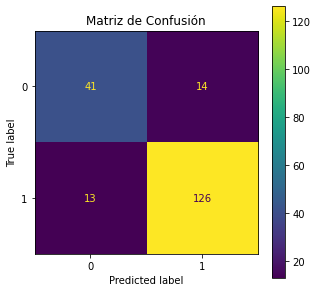

In [256]:
#Observamos que se predijieron 12 personas que no entregaron documentacion, cuando si lo hicieron
#Hay 9 personas que se predijieron entregar documentacion, cuando no fue asi

fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(regresion, X_test, y_test,ax=ax)
plt.title('Matriz de Confusión')

plt.show()

In [257]:
#Armamos un dataframe para ver la influencia de las variables en el modelo.
#Segun el modelo, hay influencia en el tiempo de antelacion de inscripcion de un interesado
# Y el tiempo que estuvo habilitada la inscripcion.
pd.DataFrame({'Variable':X.columns.values.tolist(),'Importancia':regresion.feature_importances_}).sort_values(by='Importancia',ascending=False).reset_index(drop=True)

,Variable,Importancia
0,DIASANTESDELCIERRE,0.229163
1,HABILITADO,0.157672
2,DIASDESDEINSC,0.126458
3,DIA,0.103690
4,MAESTR X,0.054539
5,ESPECIALIZACI X,0.048820
6,SEDE Y,0.047911
7,ESPECIALIZACI W,0.045624
8,MES,0.039921
9,ESPECIALIZACI A,0.031088


In [258]:
#La metrica de precision es alta
print(f"Precision Score of the classifier is: {precision_score(y_test, prediccion)}")

Precision Score of the classifier is: 0.9


In [259]:
#Ocurre lo mismo con el Recall
print(f"Recall Score of the classifier is: {recall_score(y_test, prediccion)}")

Recall Score of the classifier is: 0.9064748201438849


In [260]:
#Hacemos una prueba de predicion, dando que la persona con esos valores
#Entregaria la documentacion

prueba=np.array([0,0,6,6,2,0,53,53,0,0,0,1,0,0,0,0,0,0,0,0,0]).reshape(1,-1)


regresion.predict(prueba)


array([1], dtype=int64)

AUC for our classifier is: 0.9389797253106605


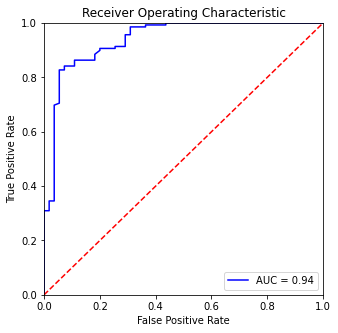

In [261]:
#La curva da bastante por encima, dando a entender que el modelo tiene sentido


from sklearn.metrics import roc_curve, auc
class_probabilities = regresion.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()